# ♟ My chess games small exploratory analysis

I made this notebook just for fun and for spark learning purposes.

In [27]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Chess data').getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark

## Downloading all my games with Lichess API
Lichess API details: https://lichess.org/api#operation/apiGamesUser

I've played many chess games, so it takes some time to download it all. You can speed up this process by specifying a personal Lichess API token. 

In [2]:
import requests
import ndjson
API_TOKEN = "" # YOUR PERSONAL TOKEN
games= requests.get("https://lichess.org/api/games/user/roykoand", headers={"Accept": "application/x-ndjson", "Authorization": f"Bearer {API_TOKEN}"}).json(cls=ndjson.Decoder)

## Last chess game on the Lichess

In [3]:
games[0]

{'id': 'CRKjpmsG',
 'rated': True,
 'variant': 'standard',
 'speed': 'blitz',
 'perf': 'blitz',
 'createdAt': 1641722949430,
 'lastMoveAt': 1641723324649,
 'status': 'outoftime',
 'players': {'white': {'user': {'name': 'oottoo', 'id': 'oottoo'},
   'rating': 1471,
   'ratingDiff': -6},
  'black': {'user': {'name': 'roykoand', 'id': 'roykoand'},
   'rating': 1465,
   'ratingDiff': 6}},
 'winner': 'black',
 'moves': 'Nh3 d5 d4 Bxh3 gxh3 Nf6 Bg5 e6 Nc3 Bb4 Bd2 Nc6 e3 e5 dxe5 Nxe5 Qe2 O-O f4 Bxc3 Bxc3 Nc6 O-O-O Re8 Bg2 Ne7 h4 c6 h5 h6 Bxf6 gxf6 Qg4+ Kh7 Bf1 Rg8 Bd3+ Kh8 Qh4 Nc8 Rhf1 f5 Qh3 Nd6 Bxf5 Nxf5 Qxf5 Qc8 Qf6+ Kh7 e4 Qe6 Qd4 Qxe4 Qxe4+ dxe4 Rd7 Rgf8 Re7 Rab8 Rxe4 a5 f5 b6 f6 Rg8 Re7 Rgf8 Rg1 Rbe8 Rg7+ Kh8 Rexf7 Rxf7 Rxf7 Kg8 Rg7+ Kh8 f7 Rf8 Rg6 Kh7 Rxc6 Rxf7 Rxb6 Rf1+ Kd2 Rf2+ Kc3 Rxh2 Ra6 Rxh5 a4 Rg5 Rb6 h5 Rb5 Kh6 Rxg5 Kxg5 Kd3 h4 Ke2 Kg4 Kf2 Kh3 Kg1 Kg3 b4 h3 b5 h2+',
 'clock': {'initial': 180, 'increment': 0, 'totalTime': 180}}

## Convert ndjson API response of games to spark dataframe

In [4]:
import json
json_dump = json.dumps(games)
jsonRDD = spark.sparkContext.parallelize([json_dump], 300)
chess_df = spark.read.json(jsonRDD)
chess_df.show(1, vertical=True) 

-RECORD 0---------------------------
 clock       | {0, 180, 180}        
 createdAt   | 1641722949430        
 daysPerTurn | null                 
 id          | CRKjpmsG             
 initialFen  | null                 
 lastMoveAt  | 1641723324649        
 moves       | Nh3 d5 d4 Bxh3 gx... 
 perf        | blitz                
 players     | {{null, null, 146... 
 rated       | true                 
 speed       | blitz                
 status      | outoftime            
 swiss       | null                 
 tournament  | null                 
 variant     | standard             
 winner      | black                
only showing top 1 row



In [5]:
chess_df.printSchema()

root
 |-- clock: struct (nullable = true)
 |    |-- increment: long (nullable = true)
 |    |-- initial: long (nullable = true)
 |    |-- totalTime: long (nullable = true)
 |-- createdAt: long (nullable = true)
 |-- daysPerTurn: long (nullable = true)
 |-- id: string (nullable = true)
 |-- initialFen: string (nullable = true)
 |-- lastMoveAt: long (nullable = true)
 |-- moves: string (nullable = true)
 |-- perf: string (nullable = true)
 |-- players: struct (nullable = true)
 |    |-- black: struct (nullable = true)
 |    |    |-- aiLevel: long (nullable = true)
 |    |    |-- provisional: boolean (nullable = true)
 |    |    |-- rating: long (nullable = true)
 |    |    |-- ratingDiff: long (nullable = true)
 |    |    |-- user: struct (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- patron: boolean (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |    |-- white: struct (null

For the sake of readability, let's convert timestamp in milliseconds to time in ```YYYYY-MM-DD HH:MM:SS``` format for ```createdAt``` and ```lastMoveAt``` column.

In [6]:
from pyspark.sql.functions import col, from_unixtime
chess_df = chess_df.withColumn("createdAt", from_unixtime(col("createdAt")/1000))\
    .withColumn("lastMoveAt", from_unixtime(col("lastMoveAt")/1000))
chess_df.select(col('createdAt'), col('lastMoveAt'))

DataFrame[createdAt: string, lastMoveAt: string]

## What are the types of chess I have played?

In [7]:
CLASSIC_CHESS_MODES = ['correspondence', 'ultraBullet', 'bullet', 'blitz', 'classical', 'rapid']
chess_df.select(col('perf')).distinct().show()

+--------------+
|          perf|
+--------------+
|      chess960|
| kingOfTheHill|
|    threeCheck|
|        atomic|
|correspondence|
|   ultraBullet|
|     antichess|
|         horde|
|   racingKings|
|         blitz|
|     classical|
|        bullet|
|         rapid|
|    crazyhouse|
+--------------+



## What is my first chess game on the Lichess?

In [30]:
from pyspark.sql.functions import min
min_date = chess_df.select(min('createdAt')).first()
first_game = chess_df.filter((col('createdAt') == min_date[0]) & col('perf').isin(CLASSIC_CHESS_MODES))
first_game.show(truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------
 clock       | {0, 60, 60}                                                                                                                                        
 createdAt   | 2019-08-17 07:27:50                                                                                                                                
 daysPerTurn | null                                                                                                                                               
 id          | lW1KkioO                                                                                                                                           
 initialFen  | null                                                                                                                                               
 lastMoveAt  | 2019-08

## Chessboard endgame position of the first game
Yeah, I played white color :)

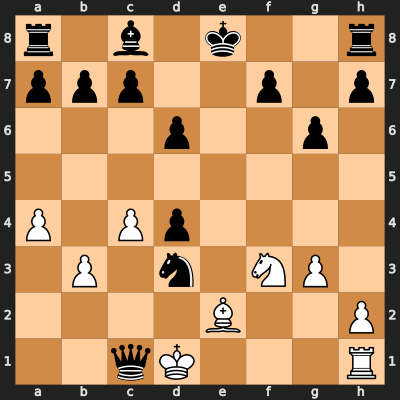

In [9]:
from PIL import Image
import chess.pgn
import cairosvg
import io

def pgn2png(game_pgn: str) -> Image:
    game = chess.pgn.read_game(io.StringIO(game_pgn))
    game = game.end()
    board = game.board()
    svg_board = chess.svg.board(board=board, size=400)
    return Image.open(io.BytesIO(cairosvg.svg2png(svg_board)))

pgn2png(first_game.select(col('moves')).first()[0])

## What is the most frequent chess game by moves?
The most common is games without moves. It happens in the Lichess tournaments, if a white player doesn't make a move. In this situation, the black player automatically becomes the winner. Let's throw out these games.

In [10]:
most_frequent_games = chess_df.where(col('perf').isin(CLASSIC_CHESS_MODES)).groupBy("moves").count().orderBy("count", "moves", ascending=False)
most_frequent_games.show(5, truncate=False)

+-----------------------------+-----+
|moves                        |count|
+-----------------------------+-----+
|                             |8    |
|e4 e5 Bc4 Nc6 Qf3 d6 Qxf7#   |4    |
|b3 g6 Bb2 Bg7 Bxg7           |4    |
|g3 e5 Bg2 Qf6 d3 Bc5 e4 Qxf2#|3    |
|g3 b6 Bg2 Bb7 Bxb7           |3    |
+-----------------------------+-----+
only showing top 5 rows



Hmmm, ```e4 e5 Bc4 Nc6 Qf3 d6 Qxf7#``` and ```g3 e5 Bg2 Qf6 d3 Bc5 e4 Qxf2#``` looks familiar. 

I remembered this pain after creating the endgame position picture (I can't imagine chess position by pgn in the mind). It's Scholar's mate.

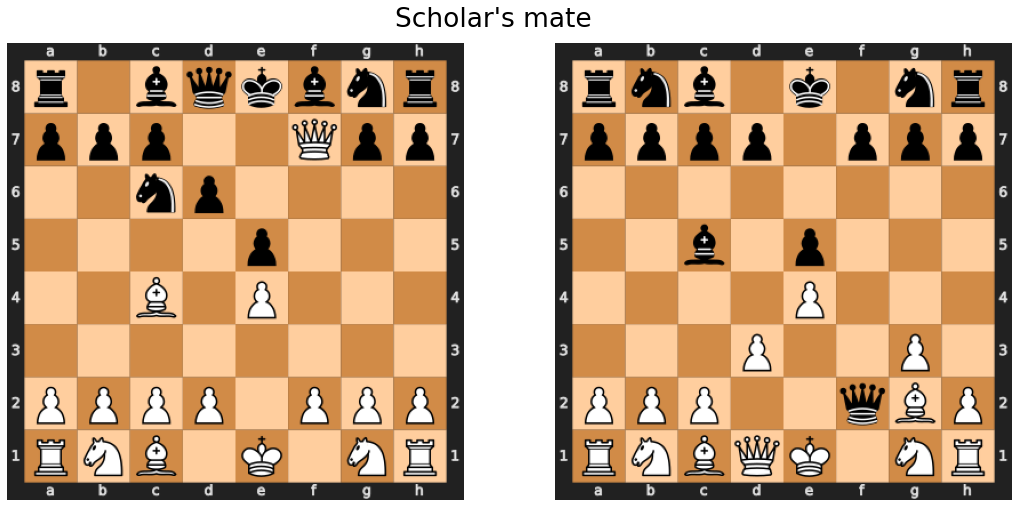

In [11]:
import matplotlib.pyplot as plt
most_frequent_games = most_frequent_games.take(5)
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax.imshow(pgn2png(most_frequent_games[1][0]))
ax2.imshow(pgn2png(most_frequent_games[3][0]))
fig.suptitle("Scholar\'s mate")
fig.subplots_adjust(top=1.1)
ax.set_axis_off()
ax2.set_axis_off()
plt.show()

## Number of games by colors

In [12]:
chess_df.createOrReplaceGlobalTempView("chess_table")
spark.sql("""
SELECT "White" AS `Color`, COUNT(*) AS `Count`
FROM global_temp.chess_table
WHERE  players.white.user.name = "roykoand"
UNION 
SELECT "Black", COUNT(*)
FROM global_temp.chess_table
WHERE  players.black.user.name = "roykoand"
UNION 
SELECT "All games", COUNT(*)
FROM global_temp.chess_table
""").show()

+---------+-----+
|    Color|Count|
+---------+-----+
|    White| 3907|
|    Black| 3888|
|All games| 7795|
+---------+-----+



## Number of games by chess game type

In [13]:
from pyspark.sql.functions import concat, lit
chess_df.select(col('perf'), concat(col('clock.totalTime'), lit(" sec.")).alias('totalTime')).groupBy('perf', 'totalTime').count().orderBy('count', ascending=False).show()

+--------------+---------+-----+
|          perf|totalTime|count|
+--------------+---------+-----+
|        bullet|  60 sec.| 3163|
|         blitz| 180 sec.| 3058|
|         blitz| 300 sec.|  344|
|         blitz| 420 sec.|  200|
|        bullet| 160 sec.|  140|
|         blitz| 260 sec.|  139|
|         rapid| 600 sec.|   90|
|        bullet|  30 sec.|   80|
|   ultraBullet|  15 sec.|   63|
|     classical|1500 sec.|   41|
|        atomic| 420 sec.|   39|
|         blitz| 340 sec.|   26|
|         rapid| 500 sec.|   25|
|correspondence|     null|   23|
|        bullet| 100 sec.|   20|
|        atomic| 180 sec.|   19|
|         blitz| 460 sec.|   19|
|         rapid| 900 sec.|   16|
|        atomic| 300 sec.|   15|
|         rapid| 700 sec.|   15|
+--------------+---------+-----+
only showing top 20 rows



## How many rated games have I played?

In [14]:
chess_df.groupBy('rated').count().show()

+-----+-----+
|rated|count|
+-----+-----+
| true| 7165|
|false|  630|
+-----+-----+



## What is the best rating that I have ever achieved?

In [15]:
chess_df.where(col('players.white.user.name') == 'roykoand').select(col('players.white.rating').alias('rating'), col('perf'))\
        .union(chess_df.where(col('players.black.user.name') == 'roykoand').select(col('players.black.rating'), col('perf'))).groupBy('perf').agg({'rating': 'max'}).show()

+--------------+-----------+
|          perf|max(rating)|
+--------------+-----------+
|      chess960|       1500|
| kingOfTheHill|       1808|
|    threeCheck|       1500|
|        atomic|       1500|
|correspondence|       1500|
|   ultraBullet|       1500|
|     antichess|       1706|
|         horde|       1589|
|   racingKings|       1741|
|         blitz|       1579|
|     classical|       1785|
|        bullet|       1761|
|         rapid|       1500|
|    crazyhouse|       1802|
+--------------+-----------+



## What is the most popular reason of my losing?

In [16]:
chess_df.where(col('perf').isin(CLASSIC_CHESS_MODES) & (((col('players.white.user.name') == 'roykoand') & (col('winner') == 'black')) | 
                                ((col('players.black.user.name') == 'roykoand') & (col('winner') == 'white'))))\
                                .groupBy('status').count().orderBy('count', ascending=False).show()

+---------+-----+
|   status|count|
+---------+-----+
|   resign| 1880|
|     mate| 1086|
|outoftime|  531|
|  timeout|   12|
|  noStart|    5|
+---------+-----+



## What is my favorite oponents?

In [17]:
chess_df.select(col('players.white.user.name')).union(chess_df.select(col('players.black.user.name'))).where(col('name') != 'roykoand').groupBy('name').count().orderBy('count', ascending=False).show(5)

+--------------------+-----+
|                name|count|
+--------------------+-----+
|           MixaKonan|  341|
|           Valrusman|   68|
|            Pisicack|   32|
|UltraBulletIsVeryFun|   11|
|             ljaksee|   11|
+--------------------+-----+
only showing top 5 rows



## When did I play the most games?

In [18]:
from pyspark.sql.functions import date_format
chess_df.select(date_format(col('lastMoveAt'), 'yyyy-MM-dd').alias('Date')).groupBy('Date').count().orderBy('count', ascending=False).show(5)

+----------+-----+
|      Date|count|
+----------+-----+
|2021-05-07|   97|
|2019-10-19|   90|
|2019-10-31|   88|
|2019-10-08|   84|
|2019-10-20|   74|
+----------+-----+
only showing top 5 rows



## How many chess games did I play by a particular year?

In [19]:
from pyspark.sql.functions import year
chess_df.select(year(col('lastMoveAt')).alias('Year')).groupBy('Year').agg({'Year': 'count'}).withColumnRenamed('count(year)', 'Year count').orderBy('Year count', ascending=False).show()

+----+----------+
|Year|Year count|
+----+----------+
|2019|      3092|
|2021|      2443|
|2020|      2191|
|2022|        69|
+----+----------+



## What is my favorite first move? 
Yeah, I prefer rat moves :)

In [20]:
from pyspark.sql.functions import split
chess_df.where(col('players.white.user.name') == 'roykoand').select(split(col('moves'), ' ', 2)[0].alias('First move'))\
        .union(chess_df.where(col('players.black.user.name') == 'roykoand').select(split(col('moves'), ' ', 3)[1])).groupby('First move').count().orderBy('count', ascending=False).show()

+----------+-----+
|First move|count|
+----------+-----+
|        g6| 1714|
|        g3| 1693|
|        e4| 1195|
|        e5| 1139|
|        d4|  683|
|        d5|  528|
|        f4|  109|
|        e6|  108|
|        c5|   88|
|       Nc6|   80|
|       Nf6|   69|
|        f5|   40|
|        b3|   37|
|        e3|   36|
|        d3|   32|
|        g4|   28|
|        g5|   28|
|        f6|   27|
|        d6|   23|
|       Nf3|   21|
+----------+-----+
only showing top 20 rows



## What is the most frequent opening in my games?
In this situation as opening, I mean the first five moves. 

In [21]:
def getfirstnmoves(pgn: str, n: int = 5):
    if pgn is None:
        return ""
    moves_split = pgn.split()
    return " ".join(moves_split[:2 * n])

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
openingUDF = udf(lambda pgn: getfirstnmoves(pgn), StringType())
openings = chess_df.where(col('perf').isin(CLASSIC_CHESS_MODES)).select(openingUDF(col('moves')).alias('opening')).groupBy('opening').count().orderBy('count', 'opening', ascending=False)
openings.show(truncate=False)

+---------------------------------------+-----+
|opening                                |count|
+---------------------------------------+-----+
|e4 g6 Nf3 Bg7 Bc4 e6 c3 Ne7 d4 O-O     |9    |
|e4 e5 Nf3 Nc6 d4 d6 dxe5 Nxe5 Nxe5 dxe5|9    |
|e4 e5 Nf3 Nc6 Bc4 d6 O-O Be6 Bxe6 fxe6 |9    |
|e4 e5 Nf3 Nc6 Bc4 d6 Nc3 Be6 Bxe6 fxe6 |8    |
|                                       |8    |
|e4 g6 d4 Bg7 e5 e6 Nf3 Ne7 Bg5 O-O     |7    |
|e4 g6 Nf3 Bg7 d4 e6 Nc3 Ne7 e5 O-O     |7    |
|e4 g6 d4 Bg7 e5 e6 f4 d6 Nf3 dxe5      |6    |
|e4 g6 d4 Bg7 e5 e6 f4 Ne7 Nf3 O-O      |6    |
|e4 g6 d4 Bg7 Nf3 e6 Nc3 Ne7 Be3 O-O    |6    |
|e4 g6 Nf3 Bg7 d4 e6 Nc3 Ne7 Be3 O-O    |6    |
|e4 g6 Nf3 Bg7 Nc3 e6 d4 Ne7 e5 O-O     |6    |
|e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Nxd4 Qxd4 d6|6    |
|e4 e5 Nf3 Nc6 Nc3 d6 d4 exd4 Nxd4 Nxd4 |6    |
|e4 e5 Nf3 Nc6 Bc4 d6 d3 Be6 Bxe6 fxe6  |6    |
|d4 g6 c4 Bg7 Nc3 e6 Nf3 Ne7 e4 O-O     |6    |
|g3 g6 Bg2 Bg7 e3 e6 Ne2 Ne7 O-O O-O    |5    |
|g3 e5 Bg2 d5 e3 e4 Ne2 Nf6 O-O Nc6     

## The most popular openings list
Unfortunately, I don't know the names of the openings, but https://www.openingtree.com/ knows.

In [23]:
import pgn2gif

def pgnstring2gif(pgn: str, pgn_name: str) -> str:
    output_filename = f'{pgn_name}.pgn'
    with open(f'{pgn_name}.pgn', 'w+') as pgn_file:
        pgn_file.write(pgn)
    creator = pgn2gif.PgnToGifCreator(reverse=True, duration=1, ws_color='white')
    creator.create_gif(output_filename) 
    return pgn_name + '.gif'

### Modern defense
https://en.wikipedia.org/wiki/Modern_Defense

In [24]:
from IPython.display import Image
Image(url=pgnstring2gif(openings.collect()[0][0], "Modern Defense"))  

### Scotch Game
https://en.wikipedia.org/wiki/Scotch_Game

In [25]:
Image(url=pgnstring2gif(openings.collect()[1][0], "Scotch Defense"))  

### Italian Game
https://en.wikipedia.org/wiki/Italian_Game

In [26]:
Image(url=pgnstring2gif(openings.collect()[3][0], "Italian Game"))  